# Kaggle Digit Recognizer Challenge - Version 4

# Importing libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score, auc, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras import losses
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import image

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Reading and setting data 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = (train.drop(['label'],axis=1).values).astype('float32')
y_train = (train.label.values).astype('int32')
X_test = test.values.astype('float32')

In [6]:
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

X_train.shape, X_test.shape

((46840, 28, 28, 1), (28000, 28, 28, 1))

# Applying scale function to independent datasets

In [8]:
# pre-processing: divide by max and substract mean
scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.std(X_train)
X_train -= mean
X_test -= mean

# Encoding dependant variable 

In [9]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [10]:
input_dim = X_train.shape[1]
nb_classes = dummy_y.shape[1]

# Creating the first neural network model

In [11]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [12]:
# define baseline model
def baseline_model():
    
    # create model
    
    model = Sequential()

    model.add(Convolution2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))
    
    model.add(Convolution2D(32,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))
    
    model.add(Convolution2D(64,(3,3), activation='relu'))
    model.add(BatchNormalization(axis=1))
    
    model.add(Convolution2D(64,(3,3), activation='relu'))
    model.add(BatchNormalization(axis=1))
    
    model.add(Flatten())
    
    model.add(Dense(512, input_dim=input_dim))
    model.add(Activation('relu'))
    
    model.add(Dense(128, input_dim=input_dim))
    model.add(Activation('relu'))
    
    model.add(Dense(nb_classes, input_dim=input_dim))
    model.add(Activation('softmax'))
   
    # Modeling
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, dummy_y, nb_epoch=12, batch_size=200, validation_split=0.1, verbose=2)
    model.optimizer.lr=0.01
    return model

# Instantiating model

In [13]:
model =  baseline_model()

Train on 42156 samples, validate on 4684 samples
Epoch 1/12
 - 154s - loss: 0.2689 - acc: 0.9161 - val_loss: 0.0329 - val_acc: 0.9898
Epoch 2/12
 - 147s - loss: 0.0734 - acc: 0.9771 - val_loss: 0.0175 - val_acc: 0.9947
Epoch 3/12
 - 142s - loss: 0.0515 - acc: 0.9838 - val_loss: 0.0218 - val_acc: 0.9919
Epoch 4/12
 - 132s - loss: 0.0434 - acc: 0.9865 - val_loss: 0.0207 - val_acc: 0.9919
Epoch 5/12
 - 130s - loss: 0.0383 - acc: 0.9880 - val_loss: 0.0132 - val_acc: 0.9959
Epoch 6/12
 - 131s - loss: 0.0320 - acc: 0.9898 - val_loss: 0.0086 - val_acc: 0.9974
Epoch 7/12
 - 130s - loss: 0.0284 - acc: 0.9910 - val_loss: 0.0069 - val_acc: 0.9981
Epoch 8/12
 - 131s - loss: 0.0235 - acc: 0.9923 - val_loss: 0.0054 - val_acc: 0.9983
Epoch 9/12
 - 130s - loss: 0.0222 - acc: 0.9929 - val_loss: 0.0049 - val_acc: 0.9983
Epoch 10/12
 - 131s - loss: 0.0185 - acc: 0.9938 - val_loss: 0.0065 - val_acc: 0.9985
Epoch 11/12
 - 129s - loss: 0.0213 - acc: 0.9929 - val_loss: 0.0060 - val_acc: 0.9979
Epoch 12/12
 -

# First model augument

In [17]:
model.optimizer.lr=0.01
gen = image.ImageDataGenerator(rotation_range=8, 
                               width_shift_range=0.15, 
                               shear_range=0.3,
                               height_shift_range=0.15, 
                               zoom_range=0.15)
batches = gen.flow(X_train, dummy_y, batch_size=64)
history = model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=2)

Epoch 1/2
46840/46840 [==============================] - 10749s 229ms/step - loss: 0.0207 - acc: 0.9935
Epoch 2/2
46840/46840 [==============================] - 10719s 229ms/step - loss: 0.0128 - acc: 0.9959


# Second model augument

In [18]:
model.optimizer.lr=0.01
gen = image.ImageDataGenerator()
batches = gen.flow(X_train, dummy_y, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1)

Epoch 1/1
46840/46840 [==============================] - 10519s 225ms/step - loss: 0.0026 - acc: 0.9992


# Submitting predictions

In [19]:
predictions = model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("submission_MC_v4.csv", index=False, header=True)

In [2]:
print('Kaggle result:', '0.99571 / 0.97485 / 0.97485 / 0.96685 / 0.63814 / 0.21428')

Kaggle result: 0.99571 / 0.97485 / 0.97485 / 0.96685 / 0.63814 / 0.21428


# Printing confusion matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[4092    0    1    1    2   11    8    5    7    5]
 [   0 4564   12   27   13    8    3   25   26    6]
 [   2    1 4097   12   11    2    3   40    8    1]
 [   0    0   10 4247    0   62    0   11   14    7]
 [   1    1    2    0 4025    1    1    6    1   34]
 [   3    0    1    3    1 3778    2    2    3    2]
 [   7    0    1    0    5   48 4073    0    3    0]
 [   0    0    8    7   10    2    0 4361    1   12]
 [   0    1    3   29    8   23    2    4 3985    8]
 [   6    0    0   17   17   14    1   39    2 4092]]
Normalized confusion matrix
[[9.90e-01 0.00e+00 2.42e-04 2.42e-04 4.84e-04 2.66e-03 1.94e-03 1.21e-03
  1.69e-03 1.21e-03]
 [0.00e+00 9.74e-01 2.56e-03 5.76e-03 2.78e-03 1.71e-03 6.40e-04 5.34e-03
  5.55e-03 1.28e-03]
 [4.79e-04 2.39e-04 9.81e-01 2.87e-03 2.63e-03 4.79e-04 7.18e-04 9.58e-03
  1.92e-03 2.39e-04]
 [0.00e+00 0.00e+00 2.30e-03 9.76e-01 0.00e+00 1.42

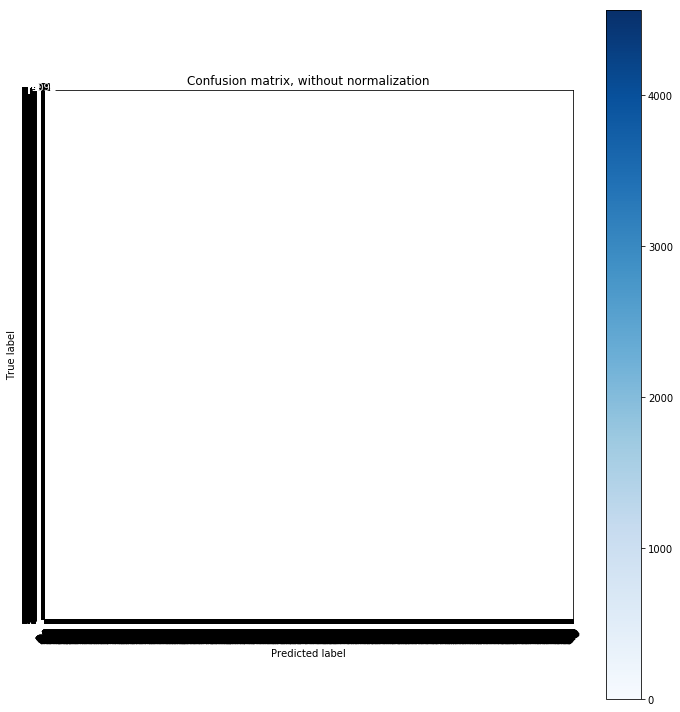

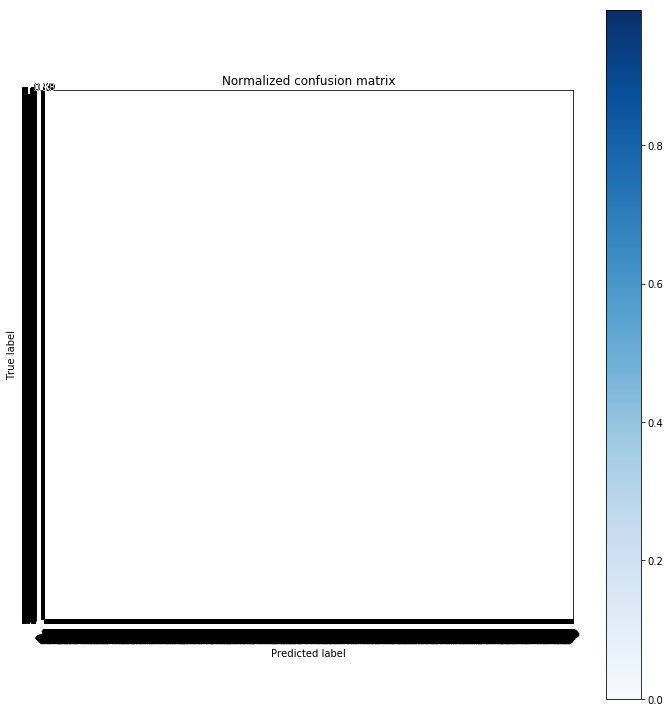

In [141]:
print(__doc__)

import itertools

class_names = train.label.values

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred_train)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()